<h1><b>Dependencies</b></h1>

This code is based on the tutorial by DigitalSreeni.<br>
Link of Tutorial: https://www.youtube.com/watch?v=97bZKO6cJfg&t=728s

In [60]:
# Python version used 3.8.10

import numpy as np # We need numpy to handle matrices of numbers and data
import tensorflow as tf # Tensorflow is the library that we will be using for simulating an LSTM model
import pandas as pd # Pandas library are for reading .csv files or other excel files
from matplotlib import pyplot as plt # Matplotlib for visualizing data or plotting it
from sklearn.preprocessing import MinMaxScaler # This is for scaling the data 

In [61]:
# Inputs
# Passenger flow
# Speed of Train

# Output 
# Passenger flow

# num of timesteps to look back = 10

In [62]:
# This code reads the csv file and saves it in a variable as a pandas data frame
# The passenger data is from https://www.kaggle.com/datasets/rakannimer/air-passengers and just invented a train_speed column to see if it is possible to add more variables in 
# the prediction 
df = pd.read_csv('../datas/train_passengers_copy.csv')

In [63]:
#Variables for training
cols = list(df)[1:3] # This picks the passengers and train speed. Change this if you want to add more features.
df_for_training = df[cols].astype(float) # Makes it a float so that we do not lose values due to rounding errors.

In [64]:
df_for_training

,#Passengers,train_speed
0,112.0,68.0
1,118.0,68.0
2,132.0,66.0
3,129.0,66.0
4,121.0,64.0
...,...,...
139,606.0,69.0
140,508.0,68.0
141,461.0,69.0
142,390.0,66.0


<AxesSubplot:>

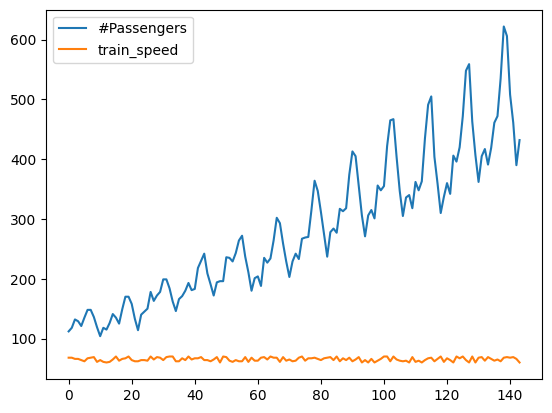

In [65]:
# Plotting the data to properly visualize it
df_for_training.plot.line()

In [66]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler()
scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [67]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

In [68]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (139, 5, 2).
trainY shape == (139, 1).


In [69]:
# Making the actual LSTM model itself
# The input shape argument means (n_past, n_features)
# n_features = train passenger flow, train speed etc.
# return_sequences = False because we do not want to output the hidden state of the LSTM each time step. We only want it to output the hidden state of the last time step.

# The number of LSTM layers to add
n_of_lstm_middle_layers = 1

model = tf.keras.Sequential() # Setting up Sequential class because the LSTM layer will be placed in order inside the Sequential class
model.add(tf.keras.layers.LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))

# Adding of middle layers in LSTM. More layers does not mean more accuracy because this depends on type of data needed to be predicted.
for i in range(n_of_lstm_middle_layers):
    model.add(tf.keras.layers.LSTM(64, return_sequences=True))
    

model.add(tf.keras.layers.LSTM(64, return_sequences=False)) # Adding of LSTM layer and specifying the hidden state and cell state size which is the first integer argument
model.add(tf.keras.layers.Dense(1)) # The very last layer is 1 neuron which takes the hidden state of the last time step and outputs it into just one number
model.compile(optimizer='adam', loss='mse') # Specifying the optimizer for backpropagation and the calculation of loss which is mean squared error
model.summary() # This just displays the layers and number of parameters in your Sequential model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 5, 64)             17152     
                                                                 
 lstm_28 (LSTM)              (None, 5, 64)             33024     
                                                                 
 lstm_29 (LSTM)              (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,265
Trainable params: 83,265
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1) # Begin training the model

Epoch 1/100
8/8 [==============================] - 9s 292ms/step - loss: 0.0906 - val_loss: 0.2031
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0362 - val_loss: 0.0490
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0270 - val_loss: 0.1070
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0233 - val_loss: 0.0430
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0144 - val_loss: 0.0458
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0128 - val_loss: 0.0602
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0483
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0123 - val_loss: 0.0460
Epoch 9/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0445
Epoch 10/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 0.0459
Epoch 11/100
8/8 [

In [71]:
# Testing the model by using the train data to predict passenger flow
prediction = model.predict(trainX)

# The reason for this code is because we need to inverse transform the output values using the scaler object.
# If we did not do this the inverse_transform function will throw an error.
# This just duplicates the column of the output so that the size of the prediction_copies matches the size of the original input data
# which is two columns passenger flow and train speed.
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1) 

# Inverse transforms the output values
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

5/5 [==============================] - 2s 3ms/step


In [72]:
# We need to adjust the predicted values based on the n_past variable.
array_adjuster = np.empty((1,n_past - 1))
array_adjuster[:] = np.nan

y_pred_future = np.append(array_adjuster, y_pred_future)


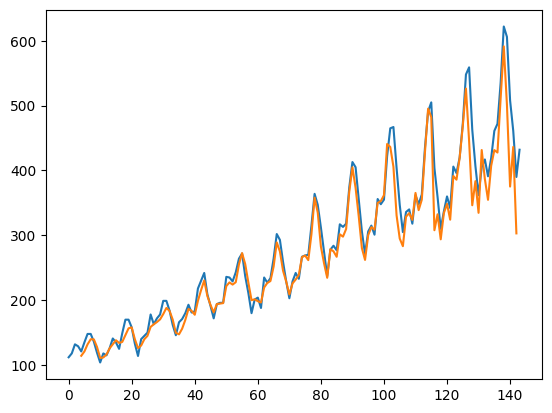

In [73]:
# Plotting the predicted values to see the difference between the actual values
plt.plot(df_for_training["#Passengers"])
plt.plot(y_pred_future)

In [74]:
# This code saves the whole trained model as a bunch of files in a folder
# model.save('../saved_param/model2')